In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [127]:
data = pd.read_csv("mnist_train.csv")

labels_numpy = data.iloc[:,0].values
pixels = data.iloc[:,1:].values
pixels[0][150:200]

array([  0,   0,   3,  18,  18,  18, 126, 136, 175,  26, 166, 255, 247,
       127,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        30,  36,  94, 154, 170, 253, 253, 253, 253, 253, 225, 172, 253,
       242, 195,  64,   0,   0,   0,   0,   0,   0,   0,   0])

In [128]:
normalized_pixels = []

# min max normalization
for subarray in pixels:
    subarray_norm = (subarray - np.min(subarray, keepdims=True)) / (np.max(subarray, keepdims=True) - np.min(subarray, keepdims=True))
    normalized_pixels.append(subarray_norm)

normalized_pixels[0][150:200]

array([0.        , 0.        , 0.01176471, 0.07058824, 0.07058824,
       0.07058824, 0.49411765, 0.53333333, 0.68627451, 0.10196078,
       0.65098039, 1.        , 0.96862745, 0.49803922, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11764706, 0.14117647, 0.36862745, 0.60392157,
       0.66666667, 0.99215686, 0.99215686, 0.99215686, 0.99215686,
       0.99215686, 0.88235294, 0.6745098 , 0.99215686, 0.94901961,
       0.76470588, 0.25098039, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [129]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

device = "mps"
torch.device(device)

device(type='mps')

In [176]:
class SimpleNetwork2(nn.Module):
    def __init__(self, input, hidden1, hidden2, hidden3, output, dropout = .2):
        super(SimpleNetwork2, self).__init__()
        self.layer1 = nn.Linear(input, hidden1)
        self.layer2 = nn.Linear(hidden1, hidden2)
        self.layer3 = nn.Linear(hidden2, hidden3)
        self.batch_norm3 = nn.BatchNorm1d(hidden3)
        self.layer4 = nn.Linear(hidden3, output)
        self.dropout = nn.Dropout(dropout)
        self.layer5 = nn.Linear(output, output)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.batch_norm3(x)
        x = F.relu(self.layer4(x))
        x = self.dropout(x)
        x = self.layer5(x)
        return x

In [177]:
model = SimpleNetwork2(1, 32, 124, 256, 784)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
epochs = 50000
batch_size = 64
sum(p.numel() for p in model.parameters())

853596

In [178]:
labels = torch.from_numpy(labels_numpy).long()
normalized_pixels = np.array(normalized_pixels)
pixels_norm = torch.from_numpy(normalized_pixels).float()

In [179]:
losses_mean = []

Current on epoch 49000 out of 50000 epochs


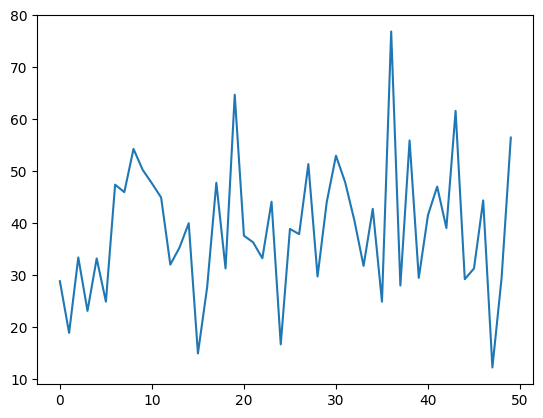

In [180]:
model.train()

for epoch in range(epochs):
    losses = []

    ix = torch.randint(0, len(labels), (batch_size,))

    label = torch.tensor(labels[ix], dtype=torch.float32)
    label = label.reshape(batch_size, 1)
    image = torch.tensor(pixels_norm[ix], dtype=torch.long)

    optimizer.zero_grad()
    predictions = model(label)
    loss = criterion(predictions, image.reshape(batch_size, -1).float())
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        losses.append(loss)
    if epoch % 1000 == 0:
        clear_output(wait=True)
        print(f"Current on epoch {epoch} out of {epochs} epochs")
        losses_mean.append(np.mean(torch.tensor(losses).detach().numpy()))
        losses = []
        plt.plot(losses_mean)
        plt.show()

In [181]:
np.mean(losses_mean)

38.847225

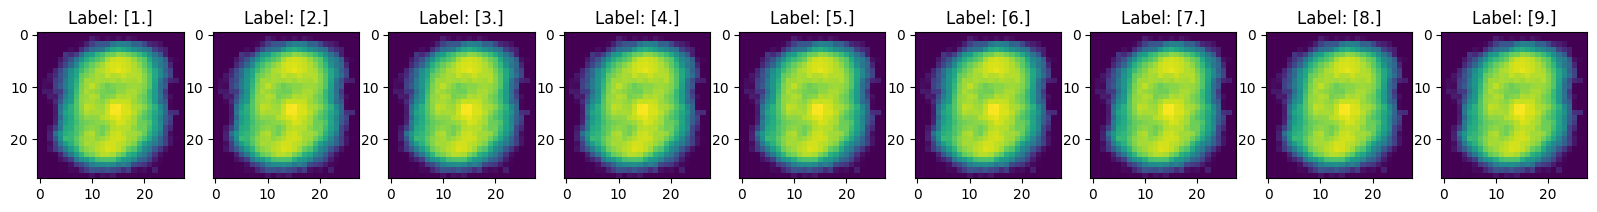

In [195]:
wish = 9
model.eval()
@torch.no_grad()
def get_prediction(wish):
    wish = torch.tensor(wish, dtype=torch.float32)
    wish = wish.reshape(1,1)
    predictions = model(wish)
    pred = predictions[0].reshape(28, 28)
    plt.imshow(pred)

@torch.no_grad()
def get_prediction2():
    fig, axs = plt.subplots(1, 9, figsize=(20, 5))
    for wish in range(1, 10):
        wish = torch.tensor(wish, dtype=torch.float32)
        wish = wish.reshape(1,1)
        predictions = model(wish)
        pred = predictions[0].reshape(28, 28)
        axs[int(wish - 1)].imshow(np.array(pred))
        axs[int(wish - 1)].set_title("Label: {}".format(np.array(wish)[0]))

get_prediction2()



## Performance Log

In [125]:
class SimpleNetwork(nn.Module):
    def __init__(self, input, hidden1, hidden2, output):
        super(SimpleNetwork, self).__init__()
        self.layer1 = nn.Linear(input, hidden1)
        self.layer2 = nn.Linear(hidden1, hidden2)
        self.layer3 = nn.Linear(hidden2, hidden2)
        self.layer4 = nn.Linear(hidden2, output)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        return x

# Mean of mean losses after 50000 epochs: 40.54
model = SimpleNetwork(1, 128, 256, 784)
sum(p.numel() for p in model.parameters())

300560

In [ ]:
# Current model: mean of mean losses after 50000 epochs: 41.887848